# Fourier Feature INR (Implicit Neural Representation) for BraTS 2023 Tumour Segmentation (JAX)

This notebook implements a coordinate-based MLP (implicit neural representation) with Fourier feature embeddings trained to predict voxel-wise tumour labels for BraTS 2023 volumes.

Instead of a 3D CNN (e.g. nnU-Net), we treat segmentation as learning a function: 
$(f: (x,y,z, m_{t_{1n}}, m_{t_{1c}}, m_{t_{2w}}, m_{t_{2f}}) \rightarrow \texttt{class logits})$.

We sample coordinates and associated multi-modal intensities to train an MLP with Fourier features for higher frequency representation capacity.

Notes: 
- This is a proof-of-concept; full convergence requires many iterations.
- Memory/time constraints mean we sample sparse coordinates per step.
- BraTS labels: 0=background, 1=NCR/NET, 2=ED, 3=ET.
- Dice scores are computed per class on a validation case.
- Compare conceptually to nnU-Net (dense 3D convolutions + data augmentation).


In [1]:
# Imports
import os, math, json, time, pathlib, functools
from typing import Tuple, Dict, Any
import numpy as np
import jax
import jax.numpy as jnp
import optax
import nibabel as nib
import wandb
from dataclasses import dataclass

print('JAX devices:', jax.devices())

JAX devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11)]


In [ ]:
# Configuration (Enhanced + Cross-Validation + W&B)
DATA_ROOT = pathlib.Path('../data/BraTS-2023')  # dataset root
SAVE_PATH = pathlib.Path('../artifacts/inr_brats23.npz')
CASE_LIMIT = 256                  # Max cases to use (subset of full set)
NUM_FOLDS = 5                     # K for K-fold cross-validation
FOLD_INDEX = 0                    # Which fold acts as validation/test (0-based)
GLOBAL_BATCH_SIZE = 32768
MICRO_BATCH_SIZE = 2048
FOURIER_FREQS = 4
HIDDEN_DIMS = [4, 512, 512, 128]
LR = 1e-4
MIN_LR = 5e-5
WARMUP_STEPS = 50
TRAIN_STEPS = 2000
VAL_CASE_INDEX = 0
RNG_SEED = 72
NUM_CLASSES = 4
DICE_WEIGHT = 0.005
CLASS_WEIGHTS = [1.0,1.0,1.0,1.0] # Background, ET, TC, WT
CLIP_NORM = 1.0

# W&B Configuration
WANDB_PROJECT = "brats-inr-segmentation"
WANDB_ENTITY = None  # Set to your wandb username/team, or leave None for default
WANDB_RUN_NAME = None  # Auto-generated if None
WANDB_TAGS = ["fourier-features", "INR", "medical-imaging", "segmentation"]
WANDB_NOTES = "Fourier Feature INR for BraTS 2023 with cross-validation"

# ACCUM steps derived from global vs micro batch
ACCUM_STEPS = (GLOBAL_BATCH_SIZE + MICRO_BATCH_SIZE - 1)//MICRO_BATCH_SIZE
print(f'Using CASE_LIMIT={CASE_LIMIT} NUM_FOLDS={NUM_FOLDS} FOLD_INDEX={FOLD_INDEX}')
jax_key = jax.random.PRNGKey(RNG_SEED)

# Initialize W&B
config = {
    "case_limit": CASE_LIMIT,
    "num_folds": NUM_FOLDS,
    "fold_index": FOLD_INDEX,
    "global_batch_size": GLOBAL_BATCH_SIZE,
    "micro_batch_size": MICRO_BATCH_SIZE,
    "accum_steps": ACCUM_STEPS,
    "fourier_freqs": FOURIER_FREQS,
    "hidden_dims": HIDDEN_DIMS,
    "learning_rate": LR,
    "min_lr": MIN_LR,
    "warmup_steps": WARMUP_STEPS,
    "train_steps": TRAIN_STEPS,
    "num_classes": NUM_CLASSES,
    "dice_weight": DICE_WEIGHT,
    "class_weights": CLASS_WEIGHTS,
    "clip_norm": CLIP_NORM,
    "rng_seed": RNG_SEED,
}

wandb.init(
    project=WANDB_PROJECT,
    entity=WANDB_ENTITY,
    name=WANDB_RUN_NAME,
    config=config,
    tags=WANDB_TAGS,
    notes=WANDB_NOTES,
)

print(f"W&B Run: {wandb.run.name}")
print(f"W&B URL: {wandb.run.url}")


Using CASE_LIMIT=256 NUM_FOLDS=5 FOLD_INDEX=0


wandb: Currently logged in as: kylelukaszek (kylelukaszek-university-of-guelph) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W&B Run: sweet-lion-62
W&B URL: https://wandb.ai/kylelukaszek-university-of-guelph/brats-inr-segmentation/runs/ga1bc39a


## Data Loading Utilities
We load each BraTS case's modalities and segmentation. Modalities are z-score normalized per volume.

In [3]:
MODALITY_SUFFIXES = ['t1n', 't1c', 't2w', 't2f']
SEG_SUFFIX = 'seg'

def find_cases(root: pathlib.Path):
    cases = []
    for p in sorted(root.iterdir()):
        if p.is_dir():
            if any((p / f'{p.name}-{m}.nii.gz').exists() for m in MODALITY_SUFFIXES):
                cases.append(p)
    return cases

def load_case(case_dir: pathlib.Path):
    base = case_dir.name
    mods = []
    for suf in MODALITY_SUFFIXES:
        fp = case_dir / f'{base}-{suf}.nii.gz'
        img = nib.load(str(fp))
        arr = img.get_fdata().astype(np.float32)
        mask = arr != 0
        if mask.any():
            mu = arr[mask].mean(); sigma = arr[mask].std() + 1e-6
            arr = (arr - mu) / sigma
        mods.append(arr)
    seg_fp = case_dir / f'{base}-{SEG_SUFFIX}.nii.gz'
    seg = nib.load(str(seg_fp)).get_fdata().astype(np.int16)
    mods_arr = np.stack(mods, axis=0)  # (M,H,W,D)
    return mods_arr, seg

# Discover and subset cases
all_cases_full = find_cases(DATA_ROOT)
subset_cases = all_cases_full[:CASE_LIMIT]
print('Total discovered:', len(all_cases_full), 'Subset used:', len(subset_cases))

# Shuffle cases deterministically and create folds
rng = np.random.default_rng(RNG_SEED)
shuffled = list(subset_cases)
rng.shuffle(shuffled)
# Split into NUM_FOLDS (last folds may differ by 1 if not divisible)
folds = np.array_split(shuffled, NUM_FOLDS)
assert 0 <= FOLD_INDEX < len(folds), 'FOLD_INDEX out of range'
val_cases = list(folds[FOLD_INDEX])
train_cases = [c for i,f in enumerate(folds) if i!=FOLD_INDEX for c in f]
print(f'Fold sizes: {[len(f) for f in folds]} | Train={len(train_cases)} Val={len(val_cases)}')

# Log dataset info to W&B
wandb.config.update({
    "total_cases": len(all_cases_full),
    "train_cases": len(train_cases),
    "val_cases": len(val_cases),
    "fold_sizes": [len(f) for f in folds],
})

# Aliases for supervised notation
X_train_cases = train_cases
Y_train_cases = train_cases  # segmentation labels paired implicitly
X_val_cases = val_cases
Y_val_cases = val_cases

# Quick peek
if len(val_cases):
    sm_mods, sm_seg = load_case(val_cases[0])
    print('Example val case modalities shape', sm_mods.shape, 'seg shape', sm_seg.shape)


Total discovered: 1251 Subset used: 256
Fold sizes: [52, 51, 51, 51, 51] | Train=204 Val=52
Example val case modalities shape (4, 240, 240, 155) seg shape (240, 240, 155)


## Coordinate + Feature Sampling
We sample random voxel coordinates and gather their modality intensities and labels for stochastic training.

In [4]:
# ============================================================================
# Streaming Data Loader - Memory Efficient Version
# ============================================================================

class StreamingBraTSCache:
    """Lightweight cache that keeps NumPy arrays and samples on-demand"""
    def __init__(self, case_paths, name="cache"):
        self.case_paths = case_paths
        self.name = name
        self.n_cases = len(case_paths)
        
        # Load cases into NumPy cache (NOT JAX)
        print(f'Building {name} cache: {self.n_cases} cases...')
        self.cache = []
        for i, cp in enumerate(case_paths):
            if i % 20 == 0 and i > 0:
                print(f'  Loaded {i}/{self.n_cases}...')
            mods, seg = load_case(cp)
            self.cache.append({
                'mods': mods,  # Keep as NumPy float32
                'seg': seg      # Keep as NumPy int16
            })
        
        # Get metadata from first case
        self.vol_shape = self.cache[0]['mods'].shape[1:]  # (H, W, D)
        self.n_modalities = self.cache[0]['mods'].shape[0]  # M
        
        # Estimate memory usage
        bytes_per_case = self.cache[0]['mods'].nbytes + self.cache[0]['seg'].nbytes
        total_gb = (bytes_per_case * self.n_cases) / 1e9
        print(f'{name} complete: {self.n_cases} cases, {total_gb:.2f} GB')
    
    def sample_voxels(self, case_indices, h_coords, w_coords, d_coords):
        """
        Gather specific voxels from cache
        
        Args:
            case_indices: (N,) which cases to sample from
            h_coords, w_coords, d_coords: (N,) spatial coordinates
            
        Returns:
            mods: (N, M) modality intensities as NumPy
            segs: (N,) segmentation labels as NumPy
        """
        N = len(case_indices)
        M = self.n_modalities
        
        mods_out = np.zeros((N, M), dtype=np.float32)
        segs_out = np.zeros(N, dtype=np.int16)
        
        for i in range(N):
            c_idx = case_indices[i]
            h, w, d = h_coords[i], w_coords[i], d_coords[i]
            mods_out[i] = self.cache[c_idx]['mods'][:, h, w, d]
            segs_out[i] = self.cache[c_idx]['seg'][h, w, d]
        
        return mods_out, segs_out

# Build streaming caches (NumPy only, not JAX!)
train_cache = StreamingBraTSCache(train_cases, name="train")
val_cache = StreamingBraTSCache(val_cases, name="val") if val_cases else None

# Extract metadata
vol_shape = train_cache.vol_shape
H, W, D = vol_shape
M = train_cache.n_modalities
C = train_cache.n_cases  # Number of training cases

print(f'Volume shape (H,W,D): {vol_shape}')
print(f'Train cases: {C} | Val cases: {len(val_cases) if val_cases else 0}')
print(f'Modalities: {M}')

# Log volume info to W&B
wandb.config.update({
    "volume_shape": vol_shape,
    "num_modalities": M,
})

# ============================================================================
# Streaming Batch Sampler - samples and converts to JAX on-the-fly
# ============================================================================

def sample_batch(rng_key, batch_size, cache=train_cache):
    """
    Sample random voxels from random cases using streaming
    
    Returns JAX arrays ready for training
    """
    key_case, key_x, key_y, key_z = jax.random.split(rng_key, 4)
    
    # Sample random indices (on CPU)
    ci = jax.random.randint(key_case, (batch_size,), 0, cache.n_cases)
    xs = jax.random.randint(key_x, (batch_size,), 0, H)
    ys = jax.random.randint(key_y, (batch_size,), 0, W)
    zs = jax.random.randint(key_z, (batch_size,), 0, D)
    
    # Convert to NumPy for gathering (JAX -> NumPy is cheap)
    ci_np = np.array(ci)
    xs_np = np.array(xs)
    ys_np = np.array(ys)
    zs_np = np.array(zs)
    
    # Gather voxels from NumPy cache
    intens_np, labels_np = cache.sample_voxels(ci_np, xs_np, ys_np, zs_np)
    
    # Build coordinates
    coords = jnp.stack([xs, ys, zs], axis=-1)
    norm_coords = (coords / jnp.array([H-1, W-1, D-1])) * 2.0 - 1.0
    
    # Convert gathered data to JAX (only the batch!)
    intens = jnp.array(intens_np)
    labels = jnp.array(labels_np, dtype=jnp.int32)
    
    return norm_coords, intens, labels

# Test the streaming sampler
test_coords, test_feats, test_labels = sample_batch(jax_key, 4)
print('Sample coords', test_coords.shape, 'feats', test_feats.shape, 'labels', test_labels.shape)
print('✓ Streaming sampler working!')

Building train cache: 204 cases...
  Loaded 20/204...
  Loaded 40/204...
  Loaded 60/204...
  Loaded 80/204...
  Loaded 100/204...
  Loaded 120/204...
  Loaded 140/204...
  Loaded 160/204...
  Loaded 180/204...
  Loaded 200/204...
train complete: 204 cases, 32.78 GB
Building val cache: 52 cases...
  Loaded 20/52...
  Loaded 40/52...
val complete: 52 cases, 8.36 GB
Volume shape (H,W,D): (240, 240, 155)
Train cases: 204 | Val cases: 52
Modalities: 4
Sample coords (4, 3) feats (4, 4) labels (4,)
✓ Streaming sampler working!


## Fourier Feature Mapping
We map 3D coordinates (normalized) to a higher-dimensional space using sinusoidal functions.

In [5]:
def fourier_features(coords: jnp.ndarray, k: int) -> jnp.ndarray:
    # coords: (B,3) in [-1,1]
    B, dim = coords.shape
    freqs = jnp.arange(1, k+1)  # (k,)
    # shape (B, dim, k)
    ang = coords[..., None] * freqs[None, None, :] * math.pi
    sin = jnp.sin(ang); cos = jnp.cos(ang)
    ff = jnp.concatenate([sin, cos], axis=-1).reshape(B, dim * 2 * k)
    return ff

def build_input(coords, intensities):
    ff = fourier_features(coords, FOURIER_FREQS)
    return jnp.concatenate([coords, ff, intensities], axis=-1)

in_dim_test = build_input(test_coords, test_feats).shape[-1]
print('Input dim:', in_dim_test)

# Log model architecture to W&B
wandb.config.update({"input_dim": in_dim_test})

Input dim: 31


## MLP Definition (Pure Functions)
We define simple MLP parameter initialization and forward apply.

In [6]:
def glorot(key, shape):
    fan_in, fan_out = shape[0], shape[1]
    limit = math.sqrt(6.0 / (fan_in + fan_out))
    return jax.random.uniform(key, shape, minval=-limit, maxval=limit)

def init_mlp(key, in_dim, hidden_dims, out_dim):
    params = []
    dims = [in_dim] + hidden_dims + [out_dim]
    for i in range(len(dims)-1):
        key, k1, k2 = jax.random.split(key, 3)
        W = glorot(k1, (dims[i], dims[i+1]))
        b = jnp.zeros((dims[i+1],))
        params.append({'W': W, 'b': b})
    return key, params

def apply_mlp(params, x):
    *hidden, last = params
    h = x
    for layer in hidden:
        h = jnp.dot(h, layer['W']) + layer['b']
        h = jax.nn.relu(h)
    out = jnp.dot(h, last['W']) + last['b']
    return out  # logits

# Initialize model
jax_key, params = init_mlp(jax_key, in_dim_test, HIDDEN_DIMS, NUM_CLASSES)
sum_params = sum(p['W'].size + p['b'].size for p in params)
print('Total parameters:', sum_params)

# Log model info to W&B
wandb.config.update({"total_parameters": sum_params})
wandb.run.summary["model_parameters"] = sum_params

Total parameters: 331524


## Loss, Optimizer, and Training Step
We use cross-entropy loss with Optax Adam optimizer.

In [7]:
# Optimizer, loss, microbatch step (with per-class metrics)
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=LR, warmup_steps=WARMUP_STEPS, decay_steps=max(1, TRAIN_STEPS-WARMUP_STEPS), end_value=MIN_LR)
optimizer = optax.chain(optax.clip_by_global_norm(CLIP_NORM), optax.adamw(schedule))
opt_state = optimizer.init(params)
cw = jnp.array(CLASS_WEIGHTS)

def one_hot(labels, num_classes):
    return jax.nn.one_hot(labels, num_classes)

def soft_dice_per_class(probs, onehot, eps=1e-6):
    inter = jnp.sum(probs * onehot, axis=0)
    sums = jnp.sum(probs, axis=0) + jnp.sum(onehot, axis=0)
    dice_k = (2*inter + eps) / (sums + eps)
    return dice_k

def loss_fn(params, coords, intensities, labels):
    x = build_input(coords, intensities)
    logits = apply_mlp(params, x)
    y = one_hot(labels, NUM_CLASSES)
    ce_vec = optax.softmax_cross_entropy(logits, y)  # (N,)
    # Weighted scalar CE for training
    w = jnp.take(cw, labels)
    ce_scalar = (ce_vec * w).mean()
    # Dice term for training
    if DICE_WEIGHT>0:
        probs = jax.nn.softmax(logits, axis=-1)
        dice_k = soft_dice_per_class(probs, y)  # (K,)
        dice_mean = dice_k.mean()
        loss = (1-DICE_WEIGHT)*ce_scalar + DICE_WEIGHT*(1-dice_mean)
    else:
        probs = jax.nn.softmax(logits, axis=-1)
        dice_k = soft_dice_per_class(probs, y)
        loss = ce_scalar
    # Per-class CE (unweighted) for reporting
    counts = jnp.sum(y, axis=0)  # (K,)
    ce_sum_k = jnp.sum(ce_vec[:, None] * y, axis=0)
    ce_mean_k = ce_sum_k / jnp.maximum(counts, 1.0)
    aux = {
        'ce_per_class': ce_mean_k,
        'dice_per_class': dice_k,
    }
    return loss, aux

loss_and_grad = jax.jit(jax.value_and_grad(loss_fn, has_aux=True))

def microbatch_step(params, opt_state, rng_key):
    grads_acc = [ {'W': jnp.zeros_like(p['W']), 'b': jnp.zeros_like(p['b'])} for p in params ]
    loss_acc = 0.0
    ce_pc_acc = jnp.zeros((NUM_CLASSES,))
    dice_pc_acc = jnp.zeros((NUM_CLASSES,))
    key = rng_key
    for _ in range(ACCUM_STEPS):
        key, sub = jax.random.split(key)
        coords, feats, labels = sample_batch(sub, MICRO_BATCH_SIZE)
        (loss_val, aux), grads = loss_and_grad(params, coords, feats, labels)
        loss_acc += float(loss_val)
        ce_pc_acc = ce_pc_acc + aux['ce_per_class']
        dice_pc_acc = dice_pc_acc + aux['dice_per_class']
        grads_acc = [ {'W': ga['W']+g['W'], 'b': ga['b']+g['b']} for ga,g in zip(grads_acc, grads) ]
    grads_mean = [ {'W': g['W']/ACCUM_STEPS, 'b': g['b']/ACCUM_STEPS} for g in grads_acc ]
    updates, opt_state = optimizer.update(grads_mean, opt_state, params)
    params = optax.apply_updates(params, updates)
    aux_mean = {
        'ce_per_class': ce_pc_acc/ACCUM_STEPS,
        'dice_per_class': dice_pc_acc/ACCUM_STEPS,
    }
    return params, opt_state, loss_acc/ACCUM_STEPS, aux_mean

# Warm-up
jax_key, warm_key = jax.random.split(jax_key)
params, opt_state, warm_loss, warm_aux = microbatch_step(params, opt_state, warm_key)
print('Warm-up loss', warm_loss)
# Log warm-up info to W&B
wandb.log({"warmup/loss": warm_loss,}, step=0)

Warm-up loss 1.273625262081623


## Training Loop
We iterate for a small number of steps (increase TRAIN_STEPS for better results).

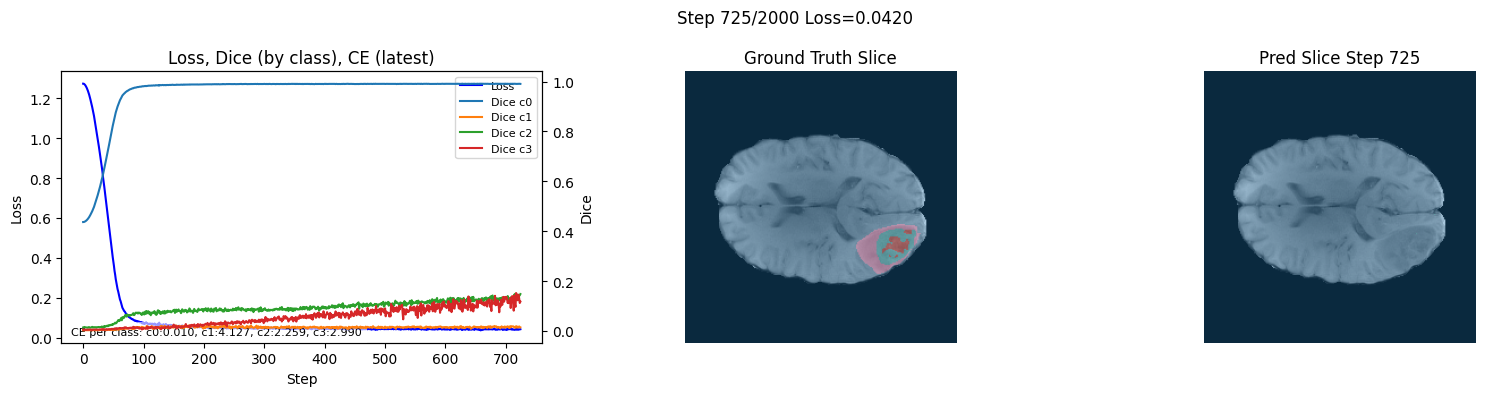

In [ ]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

loss_history = []
dice_history = [[] for _ in range(NUM_CLASSES)]
ce_history = [[] for _ in range(NUM_CLASSES)]
start = time.time()

# Get dimensions from cache instead of train_mods
H, W, D = vol_shape  # We set this in the previous cell
mid_z = D // 2

# ============================================================================
# Slice prediction helper - UPDATED for streaming
# ============================================================================

def predict_slice(params, case_index=0, z=mid_z, cache=train_cache):
    """
    Predict segmentation for a 2D slice from a cached case
    
    Args:
        params: Model parameters
        case_index: Which case in the cache (0 to cache.n_cases-1)
        z: Which z-slice to predict
        cache: StreamingBraTSCache to use (train_cache or val_cache)
    """
    # Create coordinate grid for the slice
    xs = jnp.arange(H)
    ys = jnp.arange(W)
    X, Y = jnp.meshgrid(xs, ys, indexing='ij')  # (H, W)
    x_flat = X.reshape(-1)
    y_flat = Y.reshape(-1)
    z_flat = jnp.full_like(x_flat, z)
    
    # Normalize coordinates
    coords = jnp.stack([x_flat, y_flat, z_flat], axis=-1)
    norm_coords = (coords / jnp.array([H-1, W-1, D-1])) * 2.0 - 1.0
    
    # Gather intensities from cache (NumPy)
    x_np = np.array(x_flat)
    y_np = np.array(y_flat)
    z_np = np.full(len(x_flat), z, dtype=np.int32)
    case_indices = np.full(len(x_flat), case_index, dtype=np.int32)
    
    intens_np, _ = cache.sample_voxels(case_indices, x_np, y_np, z_np)
    intens = jnp.array(intens_np)  # (H*W, M)
    
    # Build input and predict
    x_in = build_input(norm_coords, intens)
    logits = apply_mlp(params, x_in)
    pred = jnp.argmax(logits, axis=-1)
    
    return pred.reshape(H, W)

# ============================================================================
# Cache ground truth slice for visualization
# ============================================================================

# Pick a validation case for visualization (or train if no val)
vis_cache = val_cache if val_cache else train_cache
VIS_CASE_INDEX = 0  # First case in the visualization cache

# Extract ground truth slice and modality slice from cache
true_slice = vis_cache.cache[VIS_CASE_INDEX]['seg'][:, :, mid_z]
mod0_slice = vis_cache.cache[VIS_CASE_INDEX]['mods'][0, :, :, mid_z]

print(f"Visualizing case {VIS_CASE_INDEX} from {'validation' if val_cache else 'training'} set")
print(f"Slice shape: {true_slice.shape}")

# ============================================================================
# Training Loop
# ============================================================================

for step in range(1, TRAIN_STEPS + 1):
    jax_key, step_key = jax.random.split(jax_key)
    params, opt_state, loss_val, aux = microbatch_step(params, opt_state, step_key)
    loss_history.append(float(loss_val))
    dice_k = aux['dice_per_class']
    ce_k = aux['ce_per_class']
    
    # Prepare W&B metrics
    wandb_metrics = {
        "train/loss": float(loss_val),
        "train/step": step,
    }
    
    # Per-class metrics
    for k in range(NUM_CLASSES):
        dice_history[k].append(float(dice_k[k]))
        ce_history[k].append(float(ce_k[k]))
        wandb_metrics[f"train/dice_class_{k}"] = float(dice_k[k])
        wandb_metrics[f"train/ce_class_{k}"] = float(ce_k[k])
    
    # Mean metrics
    wandb_metrics["train/dice_mean"] = float(dice_k.mean())
    wandb_metrics["train/ce_mean"] = float(ce_k.mean())
    
    # Log to W&B
    wandb.log(wandb_metrics, step=step)

    if step % 25 == 0 or step == 1:
        # Predict single slice from visualization case
        pred_slice = predict_slice(params, case_index=VIS_CASE_INDEX, cache=vis_cache)
        clear_output(wait=True)
        
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))
        
        # Loss + per-class dice
        ax0 = axes[0]
        ax0.plot(loss_history, color='blue', label='Loss')
        ax0.set_title('Loss, Dice (by class), CE (latest)')
        ax0.set_xlabel('Step')
        ax0.set_ylabel('Loss')
        
        ax1 = ax0.twinx()
        colors = plt.cm.tab10.colors
        latest_ce = [h[-1] if h else float('nan') for h in ce_history]
        for k in range(NUM_CLASSES):
            ax1.plot(dice_history[k], label=f'Dice c{k}', color=colors[k % len(colors)])
        ax1.set_ylabel('Dice')
        
        # Add CE per-class as text box
        ce_text = 'CE per class: ' + ', '.join([f'c{k}:{latest_ce[k]:.3f}' for k in range(NUM_CLASSES)])
        ax0.text(0.02, 0.02, ce_text, transform=ax0.transAxes, fontsize=8, 
                va='bottom', ha='left', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
        
        # Combine legends
        lines0, labels0 = ax0.get_legend_handles_labels()
        lines1, labels1 = ax1.get_legend_handles_labels()
        ax0.legend(lines0 + lines1, labels0 + labels1, loc='upper right', fontsize=8)
        
        # Ground truth image
        axes[1].imshow(mod0_slice, cmap='gray')
        axes[1].imshow(true_slice, alpha=0.35, cmap='tab10')
        axes[1].set_title('Ground Truth Slice')
        axes[1].axis('off')
        
        # Prediction image
        axes[2].imshow(mod0_slice, cmap='gray')
        axes[2].imshow(pred_slice, alpha=0.35, cmap='tab10')
        axes[2].set_title(f'Pred Slice Step {step}')
        axes[2].axis('off')
        
        fig.suptitle(f'Step {step}/{TRAIN_STEPS} Loss={loss_val:.4f}')
        plt.tight_layout()
        display(fig)
        
        # Log figure to W&B
        wandb.log({"train/predictions": wandb.Image(fig)}, step=step)
        plt.close(fig)

training_time = time.time() - start
print(f'Training time: {training_time:.2f}s')
wandb.run.summary["training_time_seconds"] = training_time

## Evaluation (Reconstruct Full Segmentation for One Case)
We reconstruct the segmentation by querying the model on all voxel coordinates of the validation case (chosen by VAL_CASE_INDEX). Then compute Dice per class. To avoid memory overflow, we chunk coordinates.

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm

def predict_volume(params, case_data, chunk=200000):
    """
    Predict segmentation for an entire 3D volume
    
    Args:
        case_data: Dict with 'mods' and 'seg' as NumPy arrays
    """
    mods = case_data['mods']  # (M, H, W, D)
    seg_true = case_data['seg']  # (H, W, D)
    M, H, W, D = mods.shape
    
    # Build coordinate grid
    xs, ys, zs = np.arange(H), np.arange(W), np.arange(D)
    grid = np.stack(np.meshgrid(xs, ys, zs, indexing='ij'), axis=-1).reshape(-1, 3)  # (N, 3)
    intens = mods.transpose(1, 2, 3, 0).reshape(-1, M)  # Align with grid
    
    # Normalize coords
    norm_coords = (grid / np.array([H-1, W-1, D-1])) * 2.0 - 1.0
    
    # Predict in chunks to avoid OOM
    preds = []
    for i in range(0, len(grid), chunk):
        c_chunk = jnp.array(norm_coords[i:i+chunk])
        f_chunk = jnp.array(intens[i:i+chunk])
        x_in = build_input(c_chunk, f_chunk)
        logits = apply_mlp(params, x_in)
        cls = jnp.argmax(logits, axis=-1)
        preds.append(np.array(cls, dtype=np.int16))
    
    pred_flat = np.concatenate(preds, axis=0)
    pred_vol = pred_flat.reshape(H, W, D)
    
    return pred_vol, seg_true


def dice_score(pred, true, num_classes):
    """Calculate Dice score for each class"""
    scores = {}
    for c in range(num_classes):
        pred_c = (pred == c)
        true_c = (true == c)
        inter = (pred_c & true_c).sum()
        denom = pred_c.sum() + true_c.sum()
        dice = (2*inter + 1e-6) / (denom + 1e-6) if denom > 0 else np.nan
        scores[c] = dice
    return scores


def coverage_dice(pred, true):
    """
    Calculate coverage dice: measures if we predict ANY non-background class 
    where ground truth has ANY non-background class.
    This verifies spatial localization regardless of class accuracy.
    """
    pred_any = (pred > 0)  # Any non-background prediction
    true_any = (true > 0)  # Any non-background ground truth
    
    inter = (pred_any & true_any).sum()
    denom = pred_any.sum() + true_any.sum()
    
    return (2*inter + 1e-6) / (denom + 1e-6) if denom > 0 else 0.0


def evaluate_single_case(case_idx, case_data, params, num_classes):
    """Evaluate a single case - designed for parallel execution"""
    # Predict full volume
    pred_vol, true_vol = predict_volume(params, case_data, chunk=120000)
    
    # Calculate per-class Dice scores
    scores = dice_score(pred_vol, true_vol, num_classes)
    
    # Calculate coverage dice
    cov_dice = coverage_dice(pred_vol, true_vol)
    
    # Calculate mean dice (excluding NaNs)
    valid_scores = [s for s in scores.values() if not np.isnan(s)]
    mean_dice = np.mean(valid_scores) if valid_scores else 0.0
    
    return {
        'case_idx': case_idx,
        'pred_vol': pred_vol,
        'true_vol': true_vol,
        'case_data': case_data,
        'class_scores': scores,
        'coverage_dice': cov_dice,
        'mean_dice': mean_dice
    }


# ============================================================================
# Evaluate ALL validation cases in PARALLEL
# ============================================================================
print("="*80)
print("EVALUATING FULL VALIDATION SET (PARALLEL)")
print("="*80)

if val_cache and val_cache.n_cases > 0:
    eval_cache = val_cache
    eval_set = 'validation'
    n_cases = val_cache.n_cases
else:
    print("WARNING: No validation set available, using training set instead")
    eval_cache = train_cache
    eval_set = 'training'
    n_cases = min(5, train_cache.n_cases)  # Limit training eval to 5 cases

print(f"Evaluating {n_cases} {eval_set} cases in parallel...")

# Parallel evaluation with progress bar
results = []
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(evaluate_single_case, idx, eval_cache.cache[idx], params, NUM_CLASSES): idx
        for idx in range(n_cases)
    }
    
    for future in tqdm(as_completed(futures), total=n_cases, desc="Evaluating cases"):
        try:
            result = future.result()
            results.append(result)
        except Exception as e:
            case_idx = futures[future]
            print(f"\nError evaluating case {case_idx}: {e}")

# Sort results by case index
results.sort(key=lambda x: x['case_idx'])

# ============================================================================
# Aggregate results
# ============================================================================
all_dice_scores = {c: [] for c in range(NUM_CLASSES)}
all_coverage_dice = []
case_mean_dice = []

# Keep track of first case for visualization
first_case_data = results[0]['case_data'] if results else None
first_pred_vol = results[0]['pred_vol'] if results else None
first_true_vol = results[0]['true_vol'] if results else None

print("\n" + "="*80)
print("PER-CASE RESULTS")
print("="*80)

for result in results:
    case_idx = result['case_idx']
    scores = result['class_scores']
    cov_dice = result['coverage_dice']
    mean_dice = result['mean_dice']
    
    # Store for aggregation
    for c, score in scores.items():
        all_dice_scores[c].append(score)
    all_coverage_dice.append(cov_dice)
    case_mean_dice.append(mean_dice)
    
    print(f"Case {case_idx+1}/{n_cases}: {' '.join([f'c{c}={s:.3f}' for c, s in scores.items()])} | Cov={cov_dice:.3f} | Mean={mean_dice:.3f}")

# ============================================================================
# Calculate aggregate statistics
# ============================================================================
print("\n" + "="*80)
print("AGGREGATE RESULTS")
print("="*80)

mean_dice_per_class = {}
for c in range(NUM_CLASSES):
    valid_scores = [s for s in all_dice_scores[c] if not np.isnan(s)]
    if valid_scores:
        mean_dice_per_class[c] = np.mean(valid_scores)
        std_dice = np.std(valid_scores)
        print(f"Class {c}: {mean_dice_per_class[c]:.4f} ± {std_dice:.4f} (n={len(valid_scores)})")
    else:
        mean_dice_per_class[c] = 0.0
        print(f"Class {c}: No valid predictions")

overall_mean_dice = np.mean(case_mean_dice)
overall_coverage_dice = np.mean(all_coverage_dice)

print(f"\nOverall Mean Dice: {overall_mean_dice:.4f} ± {np.std(case_mean_dice):.4f}")
print(f"Coverage Dice: {overall_coverage_dice:.4f} ± {np.std(all_coverage_dice):.4f}")

# ============================================================================
# Log to W&B with bar charts
# ============================================================================
val_metrics = {
    f"val/dice_class_{c}": mean_dice_per_class[c] 
    for c in range(NUM_CLASSES)
}
val_metrics["val/dice_mean"] = overall_mean_dice
val_metrics["val/coverage_dice"] = overall_coverage_dice

# Create bar chart for class-wise dice scores
class_dice_data = [
    [c, mean_dice_per_class[c]] 
    for c in range(NUM_CLASSES)
]
val_metrics["val/dice_by_class_bar"] = wandb.plot.bar(
    wandb.Table(data=class_dice_data, columns=["Class", "Dice Score"]),
    "Class",
    "Dice Score",
    title=f"Per-Class Dice Scores ({eval_set} set)"
)

# Create bar chart comparing mean vs coverage dice
summary_data = [
    ["Mean Dice", overall_mean_dice],
    ["Coverage Dice", overall_coverage_dice]
]
val_metrics["val/dice_summary_bar"] = wandb.plot.bar(
    wandb.Table(data=summary_data, columns=["Metric", "Score"]),
    "Metric",
    "Score",
    title=f"Dice Summary ({eval_set} set)"
)

# Per-case distribution (box plot style data)
case_distribution_data = []
for case_idx in range(n_cases):
    for c in range(NUM_CLASSES):
        if not np.isnan(all_dice_scores[c][case_idx]):
            case_distribution_data.append([
                f"Class {c}", 
                all_dice_scores[c][case_idx],
                case_idx
            ])

if case_distribution_data:
    val_metrics["val/dice_distribution"] = wandb.Table(
        data=case_distribution_data,
        columns=["Class", "Dice Score", "Case Index"]
    )

# Separate scalar metrics from visualizations
scalar_metrics = {
    k: v for k, v in val_metrics.items() 
    if isinstance(v, (int, float, np.integer, np.floating))
}

chart_metrics = {
    k: v for k, v in val_metrics.items() 
    if k not in scalar_metrics
}

# Log everything together
wandb.log(val_metrics)

# Only update summary with scalar metrics
wandb.run.summary.update(scalar_metrics)

print(f"\n✓ Logged {len(scalar_metrics)} scalar metrics and {len(chart_metrics)} visualizations to W&B")
print("="*80)

# ============================================================================
# Visualize first validation case
# ============================================================================
if first_case_data is not None:
    print("\nGenerating visualization for first validation case...")
    
    import matplotlib.pyplot as plt
    
    mid_z = first_pred_vol.shape[2] // 2
    
    def _dice_macro_slice(pred2d, true2d, num_classes=4):
        scores = []
        for c in range(num_classes):
            p = (pred2d == c)
            t = (true2d == c)
            inter = (p & t).sum()
            denom = p.sum() + t.sum()
            if denom > 0:
                scores.append((2*inter + 1e-6) / (denom + 1e-6))
        return float(np.mean(scores)) if len(scores) > 0 else float('nan')
    
    def _psnr_slice(pred2d, true2d, max_val=3.0):
        mse = np.mean((np.asarray(pred2d, dtype=np.float32) - np.asarray(true2d, dtype=np.float32))**2)
        if mse <= 1e-12:
            return float('inf')
        return float(10.0 * np.log10((max_val*max_val) / (mse + 1e-12)))
    
    def visualize_modalities_with_overlays(mods, seg_gt, seg_pred, z):
        plt.ioff()  # Turn off interactive mode
        M = mods.shape[0]
        fig, axes = plt.subplots(2, M, figsize=(3*M, 6))
        if M == 1:
            axes = np.array([[axes[0]], [axes[1]]], dtype=object)
        for m in range(M):
            ax_gt = axes[0, m]
            ax_pred = axes[1, m]
            # Ground truth overlay
            ax_gt.imshow(mods[m,:,:,z], cmap='gray')
            ax_gt.imshow(seg_gt[:,:,z], cmap='tab10', alpha=0.35, vmin=0, vmax=3)
            ax_gt.set_title(f'Mod {m} + GT', fontsize=10)
            ax_gt.axis('off')
            # Prediction overlay with metrics annotation box
            ax_pred.imshow(mods[m,:,:,z], cmap='gray')
            ax_pred.imshow(seg_pred[:,:,z], cmap='tab10', alpha=0.35, vmin=0, vmax=3)
            d = _dice_macro_slice(seg_pred[:,:,z], seg_gt[:,:,z], num_classes=4)
            p = _psnr_slice(seg_pred[:,:,z], seg_gt[:,:,z], max_val=3.0)
            ax_pred.set_title(f'Mod {m} + Pred', fontsize=10)
            ax_pred.text(0.01, 0.99, f'Dice {d:.3f} PSNR {p:.2f} dB',
                       transform=ax_pred.transAxes, ha='left', va='top', fontsize=8,
                       color='yellow', bbox=dict(boxstyle='round', fc='black', alpha=0.5, pad=0.4))
            ax_pred.axis('off')
        plt.tight_layout()
        return fig
    
    # Show and log visualization
    fig = visualize_modalities_with_overlays(first_case_data['mods'], first_true_vol, first_pred_vol, mid_z)
    plt.show()
    
    # Log to W&B
    wandb.log({"val/segmentation_overlay": wandb.Image(fig)})
    plt.close(fig)
    
    print("✓ Visualization logged to W&B")

## Visualization (Middle Slices)
We show all modalities with ground-truth and predicted segmentation overlays.


In [ ]:
if first_case_data is not None:
    print("\nGenerating visualization for first validation case...")
    
    import matplotlib.pyplot as plt
    
    mid_z = first_pred_vol.shape[2] // 2
    
    def _dice_macro_slice(pred2d, true2d, num_classes=4):
        scores = []
        for c in range(num_classes):
            p = (pred2d == c)
            t = (true2d == c)
            inter = (p & t).sum()
            denom = p.sum() + t.sum()
            if denom > 0:
                scores.append((2*inter + 1e-6) / (denom + 1e-6))
        return float(np.mean(scores)) if len(scores) > 0 else float('nan')
    
    def _psnr_slice(pred2d, true2d, max_val=3.0):
        mse = np.mean((np.asarray(pred2d, dtype=np.float32) - np.asarray(true2d, dtype=np.float32))**2)
        if mse <= 1e-12:
            return float('inf')
        return float(10.0 * np.log10((max_val*max_val) / (mse + 1e-12)))
    
    def visualize_modalities_with_overlays(mods, seg_gt, seg_pred, z):
        M = mods.shape[0]
        fig, axes = plt.subplots(2, M, figsize=(3*M, 6))
        if M == 1:
            axes = np.array([[axes[0]], [axes[1]]], dtype=object)
        for m in range(M):
            ax_gt = axes[0, m]
            ax_pred = axes[1, m]
            # Ground truth overlay
            ax_gt.imshow(mods[m,:,:,z], cmap='gray')
            ax_gt.imshow(seg_gt[:,:,z], cmap='tab10', alpha=0.35, vmin=0, vmax=3)
            ax_gt.set_title(f'Mod {m} + GT', fontsize=10)
            ax_gt.axis('off')
            # Prediction overlay with metrics annotation box
            ax_pred.imshow(mods[m,:,:,z], cmap='gray')
            ax_pred.imshow(seg_pred[:,:,z], cmap='tab10', alpha=0.35, vmin=0, vmax=3)
            d = _dice_macro_slice(seg_pred[:,:,z], seg_gt[:,:,z], num_classes=4)
            p = _psnr_slice(seg_pred[:,:,z], seg_gt[:,:,z], max_val=3.0)
            ax_pred.set_title(f'Mod {m} + Pred', fontsize=10)
            ax_pred.text(0.01, 0.99, f'Dice {d:.3f} PSNR {p:.2f} dB',
                       transform=ax_pred.transAxes, ha='left', va='top', fontsize=8,
                       color='yellow', bbox=dict(boxstyle='round', fc='black', alpha=0.5, pad=0.4))
            ax_pred.axis('off')
        plt.tight_layout()
        return fig
    
    # Show and log visualization
    fig = visualize_modalities_with_overlays(first_case_data['mods'], first_true_vol, first_pred_vol, mid_z)
    plt.show()
    
    # Log to W&B
    wandb.log({"val/segmentation_overlay": wandb.Image(fig)})
    plt.close(fig)
    
    print("✓ Visualization logged to W&B")

## Save Parameters
We save learned parameters for reuse.

In [ ]:
flat_params = {}
for i, layer in enumerate(params):
    flat_params[f'W_{i}'] = np.array(layer['W'])
    flat_params[f'b_{i}'] = np.array(layer['b'])

SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)
np.savez_compressed(SAVE_PATH, **flat_params)
print('Saved parameters to', SAVE_PATH)

# Create W&B artifact for model parameters
artifact = wandb.Artifact(
    name=f"inr-model-fold{FOLD_INDEX}",
    type="model",
    description=f"Fourier Feature INR trained on BraTS 2023, fold {FOLD_INDEX}",
    metadata={
        "fold_index": FOLD_INDEX,
        "train_steps": TRAIN_STEPS,
        "final_loss": loss_history[-1] if loss_history else None,
        "val_dice_mean": val_metrics.get("val/dice_mean") if 'val_metrics' in locals() else None,
        "architecture": {
            "input_dim": in_dim_test,
            "hidden_dims": HIDDEN_DIMS,
            "num_classes": NUM_CLASSES,
            "fourier_freqs": FOURIER_FREQS,
        }
    }
)
artifact.add_file(str(SAVE_PATH))
wandb.log_artifact(artifact)
print(f"Logged model artifact to W&B: {artifact.name}")

## Next Steps
- Increase TRAIN_STEPS, CASE_LIMIT for better accuracy.
- Add class rebalancing or focal loss (BraTS class imbalance).
- Integrate data augmentations (intensity shifts, coordinate jitter).
- Compare against nnU-Net baseline metrics.
- Explore multi-resolution coordinate conditioning or SIREN activations.

## Hold-Out Case Evaluation
We evaluate the model on a case not included in the training subset (beyond CASE_LIMIT). If unavailable, we skip.


In [ ]:
all_cases_full = find_cases(DATA_ROOT)
extra_cases = all_cases_full[CASE_LIMIT:]
print('Hold-out cases available:', len(extra_cases))

if len(extra_cases) > 0:
    hold_case_path = extra_cases[1]
    hold_mods, hold_seg = load_case(hold_case_path)
    hold_case_data = {'mods': hold_mods, 'seg': hold_seg}
    hold_pred, hold_true = predict_volume(params, hold_case_data, chunk=120000)
    hold_scores = dice_score(hold_pred, hold_true, NUM_CLASSES)
    print('Hold-out Dice:', hold_scores)
    
    # Log hold-out metrics to W&B
    holdout_metrics = {f"holdout/dice_class_{c}": score for c, score in hold_scores.items()}
    holdout_metrics["holdout/dice_mean"] = np.nanmean(list(hold_scores.values()))
    wandb.log(holdout_metrics)
    wandb.run.summary.update(holdout_metrics)
    
    mid_z_hold = hold_pred.shape[2]//2
    fig = visualize_modalities_with_overlays(hold_mods, hold_true, hold_pred, mid_z_hold)
    plt.show()
    
    # Log hold-out visualization to W&B
    wandb.log({"holdout/segmentation_overlay": wandb.Image(fig)})
    plt.close(fig)
else:
    print('No hold-out case beyond training CASE_LIMIT to evaluate.')

## Interactive Viewer (Hold-outs)
Use the dropdown to select a hold-out case and slider to browse slices. The layout (all modalities with GT and Pred overlays) remains fixed; only the slice changes.

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pathlib as _pl

# Prepare hold-out cases list
all_cases_full = find_cases(DATA_ROOT)
extra_cases = all_cases_full[CASE_LIMIT:]
case_options = [(p.name, str(p)) for p in extra_cases]
print('Hold-out cases:', len(case_options))

hold_pred_cache = {}  # path -> pred volume
state = {'mods': None, 'true': None, 'pred': None}

def load_and_predict_cached(case_path_str):
    p = _pl.Path(case_path_str)
    mods, seg = load_case(p)
    if case_path_str not in hold_pred_cache:
        pred, _ = predict_volume(params, {'mods': mods, 'seg': seg}, chunk=120000)
        hold_pred_cache[case_path_str] = pred
    return mods, seg, hold_pred_cache[case_path_str]

# Define visualization function once here to avoid redefinition issues
def _dice_macro_slice(pred2d, true2d, num_classes=4):
    scores = []
    for c in range(num_classes):
        p = (pred2d == c)
        t = (true2d == c)
        inter = (p & t).sum()
        denom = p.sum() + t.sum()
        if denom > 0:
            scores.append((2*inter + 1e-6) / (denom + 1e-6))
    return float(np.mean(scores)) if len(scores) > 0 else float('nan')

def _psnr_slice(pred2d, true2d, max_val=3.0):
    mse = np.mean((np.asarray(pred2d, dtype=np.float32) - np.asarray(true2d, dtype=np.float32))**2)
    if mse <= 1e-12:
        return float('inf')
    return float(10.0 * np.log10((max_val*max_val) / (mse + 1e-12)))

def visualize_modalities_with_overlays(mods, seg_gt, seg_pred, z):
    plt.ioff()  # Turn off interactive mode
    M = mods.shape[0]
    fig, axes = plt.subplots(2, M, figsize=(3*M, 6))
    if M == 1:
        axes = np.array([[axes[0]], [axes[1]]], dtype=object)
    for m in range(M):
        ax_gt = axes[0, m]
        ax_pred = axes[1, m]
        # Ground truth overlay
        ax_gt.imshow(mods[m,:,:,z], cmap='gray')
        ax_gt.imshow(seg_gt[:,:,z], cmap='tab10', alpha=0.35, vmin=0, vmax=3)
        ax_gt.set_title(f'Mod {m} + GT', fontsize=10)
        ax_gt.axis('off')
        # Prediction overlay with metrics annotation box
        ax_pred.imshow(mods[m,:,:,z], cmap='gray')
        ax_pred.imshow(seg_pred[:,:,z], cmap='tab10', alpha=0.35, vmin=0, vmax=3)
        d = _dice_macro_slice(seg_pred[:,:,z], seg_gt[:,:,z], num_classes=4)
        p = _psnr_slice(seg_pred[:,:,z], seg_gt[:,:,z], max_val=3.0)
        ax_pred.set_title(f'Mod {m} + Pred', fontsize=10)
        ax_pred.text(0.01, 0.99, f'Dice {d:.3f} PSNR {p:.2f} dB',
                   transform=ax_pred.transAxes, ha='left', va='top', fontsize=8,
                   color='yellow', bbox=dict(boxstyle='round', fc='black', alpha=0.5, pad=0.4))
        ax_pred.axis('off')
    plt.tight_layout()
    return fig

out = widgets.Output()
if len(case_options) == 0:
    print('No hold-out cases available to visualize.')
else:
    dd_hold = widgets.Dropdown(options=case_options, description='Hold-out:')
    # Initialize
    state['mods'], state['true'], state['pred'] = load_and_predict_cached(dd_hold.value)
    z_slider = widgets.IntSlider(min=0, max=int(state['pred'].shape[2]-1), value=int(state['pred'].shape[2]//2), description='Slice z')

    def render_slice(z):
        with out:
            clear_output(wait=True)
            fig = visualize_modalities_with_overlays(state['mods'], state['true'], state['pred'], int(z))
            display(fig)
            plt.close(fig)

    def on_slice_change(change):
        render_slice(change['new'])

    def on_case_change(change):
        # Load new case
        state['mods'], state['true'], state['pred'] = load_and_predict_cached(change['new'])
        
        # Update slider bounds
        z_slider.unobserve(on_slice_change, names='value')
        z_slider.max = int(state['pred'].shape[2]-1)
        z_slider.value = int(state['pred'].shape[2]//2)
        z_slider.observe(on_slice_change, names='value')
        
        # Log explored case to W&B
        case_name = _pl.Path(change['new']).name
        case_scores = dice_score(state['pred'], state['true'], NUM_CLASSES)
        case_metrics = {
            f"interactive/{case_name}/dice_class_{c}": score 
            for c, score in case_scores.items()
        }
        case_metrics[f"interactive/{case_name}/dice_mean"] = np.nanmean(list(case_scores.values()))
        wandb.log(case_metrics)
        
        # Render once
        render_slice(z_slider.value)

    z_slider.observe(on_slice_change, names='value')
    dd_hold.observe(on_case_change, names='value')
    display(widgets.VBox([dd_hold, z_slider, out]))
    
    # Initial render - only call once
    render_slice(z_slider.value)

In [ ]:
wandb.finish()